In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import warnings

## Main regression model

In [2]:
# load dataset
cleaned = pd.read_csv('regression_predictors.csv')

# log-transformed outcome
cleaned['log_loss_m2'] = np.log1p(cleaned['loss_m2'])

model_log = smf.ols(
    'log_loss_m2 ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:            log_loss_m2   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     37.39
Date:                Sat, 26 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:10:54   Log-Likelihood:                -3150.7
No. Observations:                1904   AIC:                             6531.
Df Residuals:                    1789   BIC:                             7170.
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

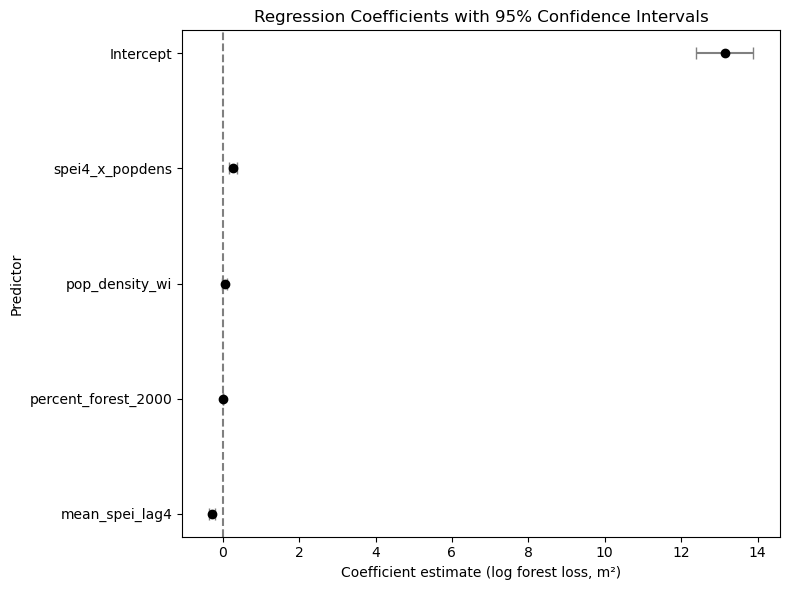

In [5]:
# extract coefficients and confidence intervals
coefs = model_log.summary2().tables[1]
coefs = coefs.reset_index().rename(columns={'index': 'predictor'})

# filter out district fixed effects
coefs = coefs[~coefs['predictor'].str.startswith('C(district)')]

# create columns for plotting
predictors = coefs['predictor']
estimates = coefs['Coef.']
lower_ci = coefs['[0.025']
upper_ci = coefs['0.975]']
error = [estimates - lower_ci, upper_ci - estimates]

# sort predictors
sorted_idx = estimates.argsort()
predictors = predictors.iloc[sorted_idx]
estimates = estimates.iloc[sorted_idx]
error = [error[0].iloc[sorted_idx], error[1].iloc[sorted_idx]]

# plot
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=estimates, y=predictors,
    xerr=error, fmt='o', capsize=4, markersize=6,
    linestyle='none', color='black', ecolor='gray'
)

# Add vertical reference line at 0
plt.axvline(0, color='gray', linestyle='--')

# Labels
plt.xlabel('Coefficient estimate (log forest loss, m²)')
plt.ylabel('Predictor')
plt.title('Regression Coefficients with 95% Confidence Intervals')

plt.tight_layout()
plt.show()

## Plot average effects

In [7]:
# define range for mean lagged SPEI
x_vals = np.linspace(cleaned['mean_spei_lag4'].min(), cleaned['mean_spei_lag4'].max(), 100)

pop_density_mean = cleaned['pop_density_wi'].mean()
percent_forest_mean = cleaned['percent_forest_2000'].mean()

# set reference district
ref_district = cleaned['district'].unique()[0]

# build dataframe
pred_df = pd.DataFrame({
    'mean_spei_lag4': spei_range,
    'pop_density_wi': pop_density_mean,
    'spei4_x_popdens': spei_range * pop_density_mean,
    'percent_forest_2000': percent_forest_mean,
    'district': ref_district
})

y_pred = model_log.predict(pred_df)

plt.scatter(cleaned['mean_spei_lag4'], cleaned['log_loss_m2'], alpha=0.3, label='Observed')
plt.plot(x_vals, y_pred, color='red', label='Average effect of SPEI lag4')
plt.xlabel('Mean SPEI (lag 4)')
plt.ylabel('Log-transformed forest loss (m²)')
plt.legend()
plt.title('Average Effect of Mean SPEI (lag 4) on Log Forest Loss')
plt.show()

NameError: name 'spei_range' is not defined

## Per-district regression models

In [8]:
# isolate districts
districts = cleaned['district'].unique()

# create empty list to store results
results = []

# loop over districts
for district in districts:
    df_district = cleaned[cleaned['district'] == district]
    # skip if too few rows
    if len(df_district) < 10:
        print(f'skipping {district}')
        continue

    try:
        model = smf.ols(
            'log_loss_m2 ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + percent_forest_2000',
            data=df_district
        ).fit()
        # extract coefficients
        coefs = model.summary2().tables[1]
        coefs = coefs.reset_index().rename(columns={'index': 'term'})
        coefs['district'] = district
        # add to results
        results.append(coefs)

    except Exception as e:
        print(f'error in {district}: {e}')

# combine all results
all_results = pd.concat(results, ignore_index=True)

# export to csv
all_results.to_csv('district_level_regression.csv', index=False)

/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  k, _ = kurtosistest(a, axis)
/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  k, _ = kurtosistest(a, axis)
/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  k, _ = kurtosistest(a, axis)
/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  k, _ = kurtosistest(a, axis)
/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosis

In [9]:
# load district-level regression results
all_results = pd.read_csv('district_level_regression.csv')

# filter to lagged SPEI terms
spei_results = all_results[all_results['term'] == 'spei4_x_popdens']

# keep only significant districts
significant_spei = spei_results[spei_results['P>|t|'] < 0.05]

# get district names
significant_districts = significant_spei['district'].unique().tolist()

print(f'Significant districts (lagged SPEI effect): {significant_districts}')

Significant districts (lagged SPEI effect): ['Choma', 'Chongwe', 'Kalulushi', 'Kanchibiya', 'Katete', 'Luangwa', 'Lufwanyama', 'Lusaka', 'Masaiti', 'Mpongwe', 'Ndola', 'Zimba']


/tmp/ipykernel_1431805/1158713373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_spei['abs_coef'] = significant_spei['Coef.'].abs()


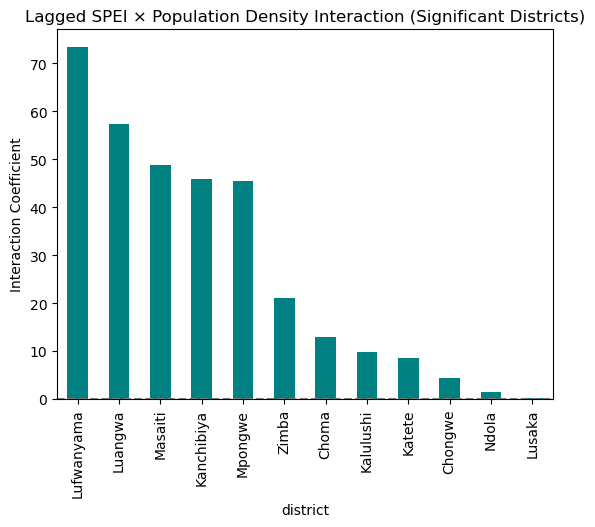

In [12]:
significant_spei['abs_coef'] = significant_spei['Coef.'].abs()
ranked = significant_spei.sort_values('abs_coef', ascending=False)

ranked.plot.bar(x='district', y='Coef.', color='teal', legend=False)
plt.ylabel('Interaction Coefficient')
plt.title('Lagged SPEI × Population Density Interaction (Significant Districts)')
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [4]:
# list of significant districts
significant_districts = districts_gdf[districts_gdf['significant'] == True]['district'].tolist()
significant_districts

['Chibombo',
 'Kabwe',
 'Mkushi',
 'Mumbwa',
 'Serenje',
 'Lufwanyama',
 'Masaiti',
 'Mpongwe',
 'Ndola',
 'Lundazi',
 'Mambwe',
 'Kawambwa',
 'Mansa',
 'Mwense',
 'Nchelenge',
 'Samfya',
 'Lusaka',
 'Chama',
 'Chinsali',
 'Mpika',
 'Nakonde',
 'Kabompo',
 'Kasempa',
 'Mufumbwe',
 'Mwinilunga',
 'Solwezi',
 'Zambezi',
 'Chilubi',
 'Kaputa',
 'Kasama',
 'Mporokoso',
 'Mungwi',
 'Livingstone',
 'Namwala',
 'Kalabo',
 'Kaoma',
 'Lukulu',
 'Mongu',
 'Senanga',
 'Sesheke',
 "Shang'Ombo"]

## Charcoal production regression model

In [8]:
# load charcoal production dataset
charcoal_df = pd.read_csv('charcoal_points.csv')

# prepare charcoal counts
charcoal_df.rename(columns={'charcoal': 'charcoal_count'}, inplace=True)

# load urban proximity dataframe
urban_dist = pd.read_csv('urban_proximity.csv')

# keep only surveyed districts (HICPS)
surveyed_districts = charcoal_df['district'].unique()
cleaned = cleaned[cleaned['district'].isin(surveyed_districts)].copy()

# create mapping from district to charcoal count
charcoal_map = dict(zip(charcoal_df['district'], charcoal_df['charcoal_count']))

# merge charcoal and distance data
cleaned['charcoal_count'] = cleaned['district'].map(charcoal_map).fillna(0)
cleaned['log_charcoal_count'] = np.log1p(cleaned['charcoal_count'])

# merge in urban distance
cleaned = cleaned.merge(urban_dist, on='district', how='left')
cleaned['min_dist_to_urban_km'] = cleaned['min_dist_to_urban_km'].fillna(0.001)

# create interaction term
cleaned['log_dist_x_charcoal'] = cleaned['min_dist_to_urban_km'] * cleaned['log_charcoal_count']

#charcoal_districts = cleaned[cleaned['charcoal_count'] > 0].copy()

model_charcoal = smf.ols(
    'log_loss_m2 ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + '
    'percent_forest_2000 + min_dist_to_urban_km + log_charcoal_count + '
    'log_dist_x_charcoal + C(district)',
    data=cleaned
).fit()

print(model_charcoal.summary())

                            OLS Regression Results                            
Dep. Variable:            log_loss_m2   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     28.38
Date:                Sat, 26 Jul 2025   Prob (F-statistic):           3.05e-36
Time:                        12:21:12   Log-Likelihood:                -337.10
No. Observations:                 187   AIC:                             702.2
Df Residuals:                     173   BIC:                             747.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## All lags (1-5)

In [5]:
# log total forest loss

results = []

for lag in range(1, 6):
    spei_col = f'mean_spei_lag{lag}'
    interaction = f'spei{lag}_x_popdens'
    
    # create interaction term dynamically
    cleaned[interaction] = cleaned[spei_col] * cleaned['pop_density_wi']

    # define and run model
    formula = f'log_loss_m2 ~ {spei_col} + pop_density_wi + {interaction} + percent_forest_2000 + C(district)'
    model = smf.ols(formula=formula, data=cleaned).fit()

    # store summary stats
    results.append({
        'Lag': lag,
        'SPEI coef': model.params.get(spei_col, float('nan')),
        'SPEI pval': model.pvalues.get(spei_col, float('nan')),
        'Interaction coef': model.params.get(interaction, float('nan')),
        'Interaction pval': model.pvalues.get(interaction, float('nan')),
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic
    })

# convert results to table
results_df = pd.DataFrame(results)
results_df

,Lag,SPEI coef,SPEI pval,Interaction coef,Interaction pval,R-squared,Adj. R-squared,AIC,BIC
0,1,-0.060351,1.104982e-01,0.163445,1.312909e-02,0.692965,0.673399,6603.360030,7241.806935
1,2,-0.146737,1.050303e-04,0.061090,4.035207e-01,0.694113,0.674621,6596.228226,7234.675131
2,3,-0.146761,1.044551e-04,0.245276,2.244060e-04,0.696139,0.676776,6583.571533,7222.018438
3,4,-0.277050,1.695185e-13,0.263977,2.244892e-07,0.704358,0.685519,6531.364046,7169.810951
4,5,-0.123534,1.886134e-03,0.054285,2.354955e-01,0.705263,0.685227,6123.473486,6754.948560


## Plot

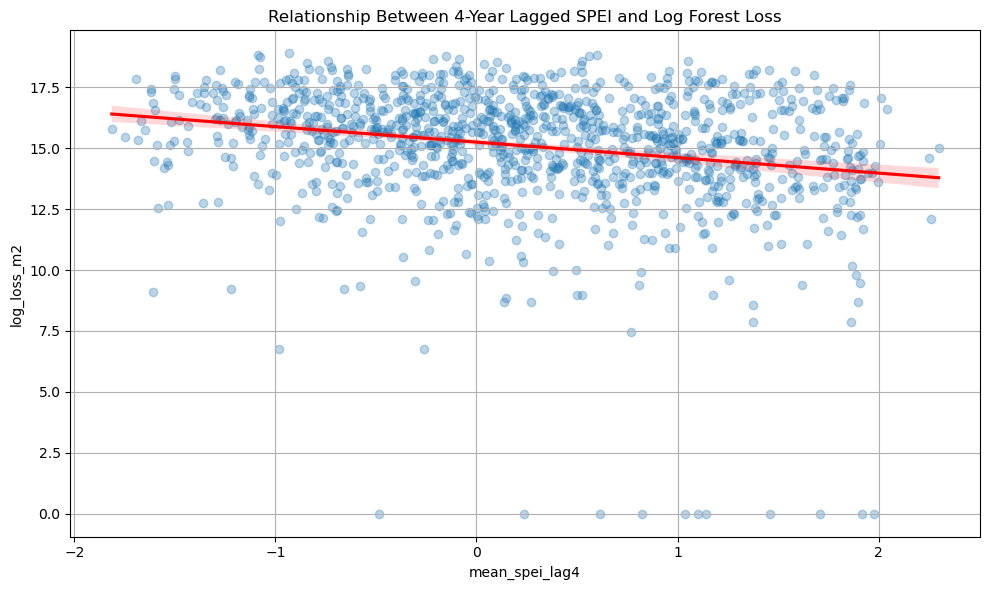

In [6]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=cleaned,
    x='mean_spei_lag4',
    y='log_loss_m2',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

plt.title('Relationship Between 4-Year Lagged SPEI and Log Forest Loss')
plt.xlabel('mean_spei_lag4')
plt.ylabel('log_loss_m2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Charcoal buffer proximity analysis

In [6]:
# load survey data
df = pd.read_csv('Data/Charc.csv')

# filter for charcoal-producing households
charcoal_df = df[df['Charc'] == 1].copy()

# convert to geodataframe
charcoal_gdf = gpd.GeoDataFrame(
    charcoal_df,
    geometry=gpd.points_from_xy(charcoal_df.longitude, charcoal_df.latitude),
    crs='EPSG:4326'
)

# charcoal production counts by district
charcoal_counts = (
    df[df['Charc'] == 1]
    .groupby('district')
    .size()
    .reset_index(name='charcoal')
)

# merge with shapefile
merged = districts_gdf.merge(charcoal_counts, on='district', how='left')
merged['charcoal'] = merged['charcoal'].fillna(0)

charcoal_production = merged[merged['charcoal'] > 0].copy()

charcoal_production_utm = charcoal_production.to_crs(epsg=32735)

# get centroids
charcoal_production_utm['centroid'] = charcoal_production_utm.geometry.centroid

# create gdf of points
charcoal_points = gpd.GeoDataFrame(
    charcoal_production_utm[['district', 'charcoal']],
    geometry=charcoal_production_utm['centroid'],
    crs=charcoal_production_utm.crs
)

charcoal_points = charcoal_points.to_crs(epsg=4326)

# Extract longitude and latitude from Point geometry
charcoal_points['longitude'] = charcoal_points.geometry.x
charcoal_points['latitude'] = charcoal_points.geometry.y

# Drop the geometry column (optional)
charcoal_points_csv = charcoal_points.drop(columns='geometry')

# Export to CSV
charcoal_points_csv.to_csv('charcoal_points.csv', index=False)

# add buffers
charcoal_points_utm = charcoal_points.to_crs(epsg=32735)
districts_gdf_utm = districts_gdf.to_crs(epsg=32735)

# create 25 and 50 km buffers (in meters)
buffer_25km = charcoal_points_utm.buffer(25000)
buffer_50km = charcoal_points_utm.buffer(50000)

# convert buffers to geodataframes
buffer_25km_gdf = gpd.GeoDataFrame(geometry=buffer_25km, crs=charcoal_points_utm.crs)
buffer_50km_gdf = gpd.GeoDataFrame(geometry=buffer_50km, crs=charcoal_points_utm.crs)

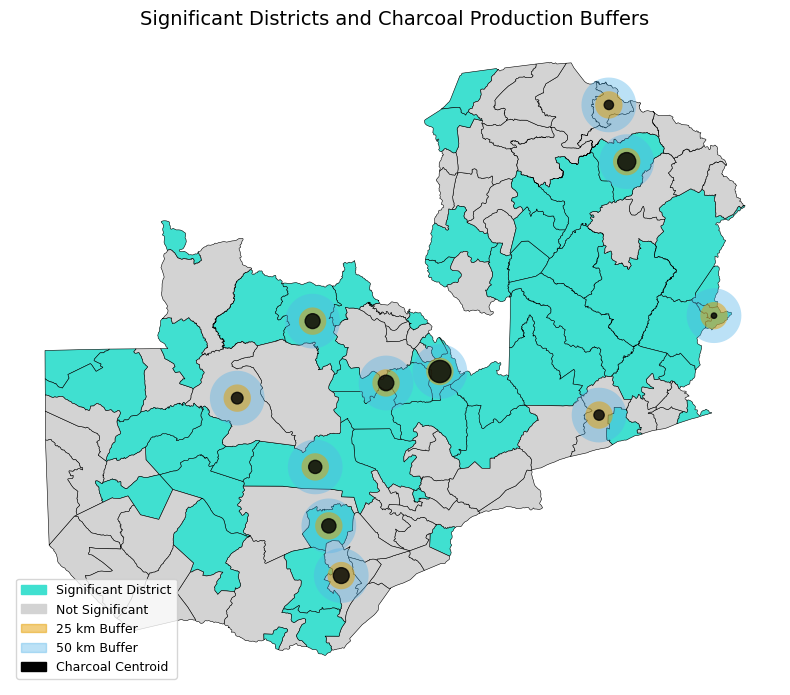

In [7]:
# reproject the base layer to match buffer CRS
districts_plot = districts_gdf.to_crs(epsg=32735)

# start new figure 
fig, ax = plt.subplots(figsize=(8, 10))

# plot base layer
districts_plot.plot(ax=ax, color=districts_plot['color'], edgecolor='black', linewidth=0.4)

# plot buffers
buffer_50km_gdf.plot(ax=ax, color='#56B4E9', alpha=0.4, edgecolor='none', label='50 km Buffer')
buffer_25km_gdf.plot(ax=ax, color='#E69F00', alpha=0.5, edgecolor='none', label='25 km Buffer')

# plot charcoal centroids
charcoal_points_utm.plot(
    ax=ax,
    color='black',
    markersize=charcoal_points_utm['charcoal'] * 5,  # scale this multiplier as needed
    alpha=0.8,
    label='Charcoal Centroid (Scaled)'
)

# add title and legend
ax.set_title('Significant Districts and Charcoal Production Buffers', fontsize=14)
ax.axis('off')

# create legend
legend_handles = [
    mpatches.Patch(color='#40E0D0', label='Significant District'),
    mpatches.Patch(color='lightgray', label='Not Significant'),
    mpatches.Patch(color='#E69F00', alpha=0.5, label='25 km Buffer'),
    mpatches.Patch(color='#56B4E9', alpha=0.4, label='50 km Buffer'),
    mpatches.Patch(color='black', label='Charcoal Centroid')
]

ax.legend(handles=legend_handles, loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()

# Statistically significant district scatterplots

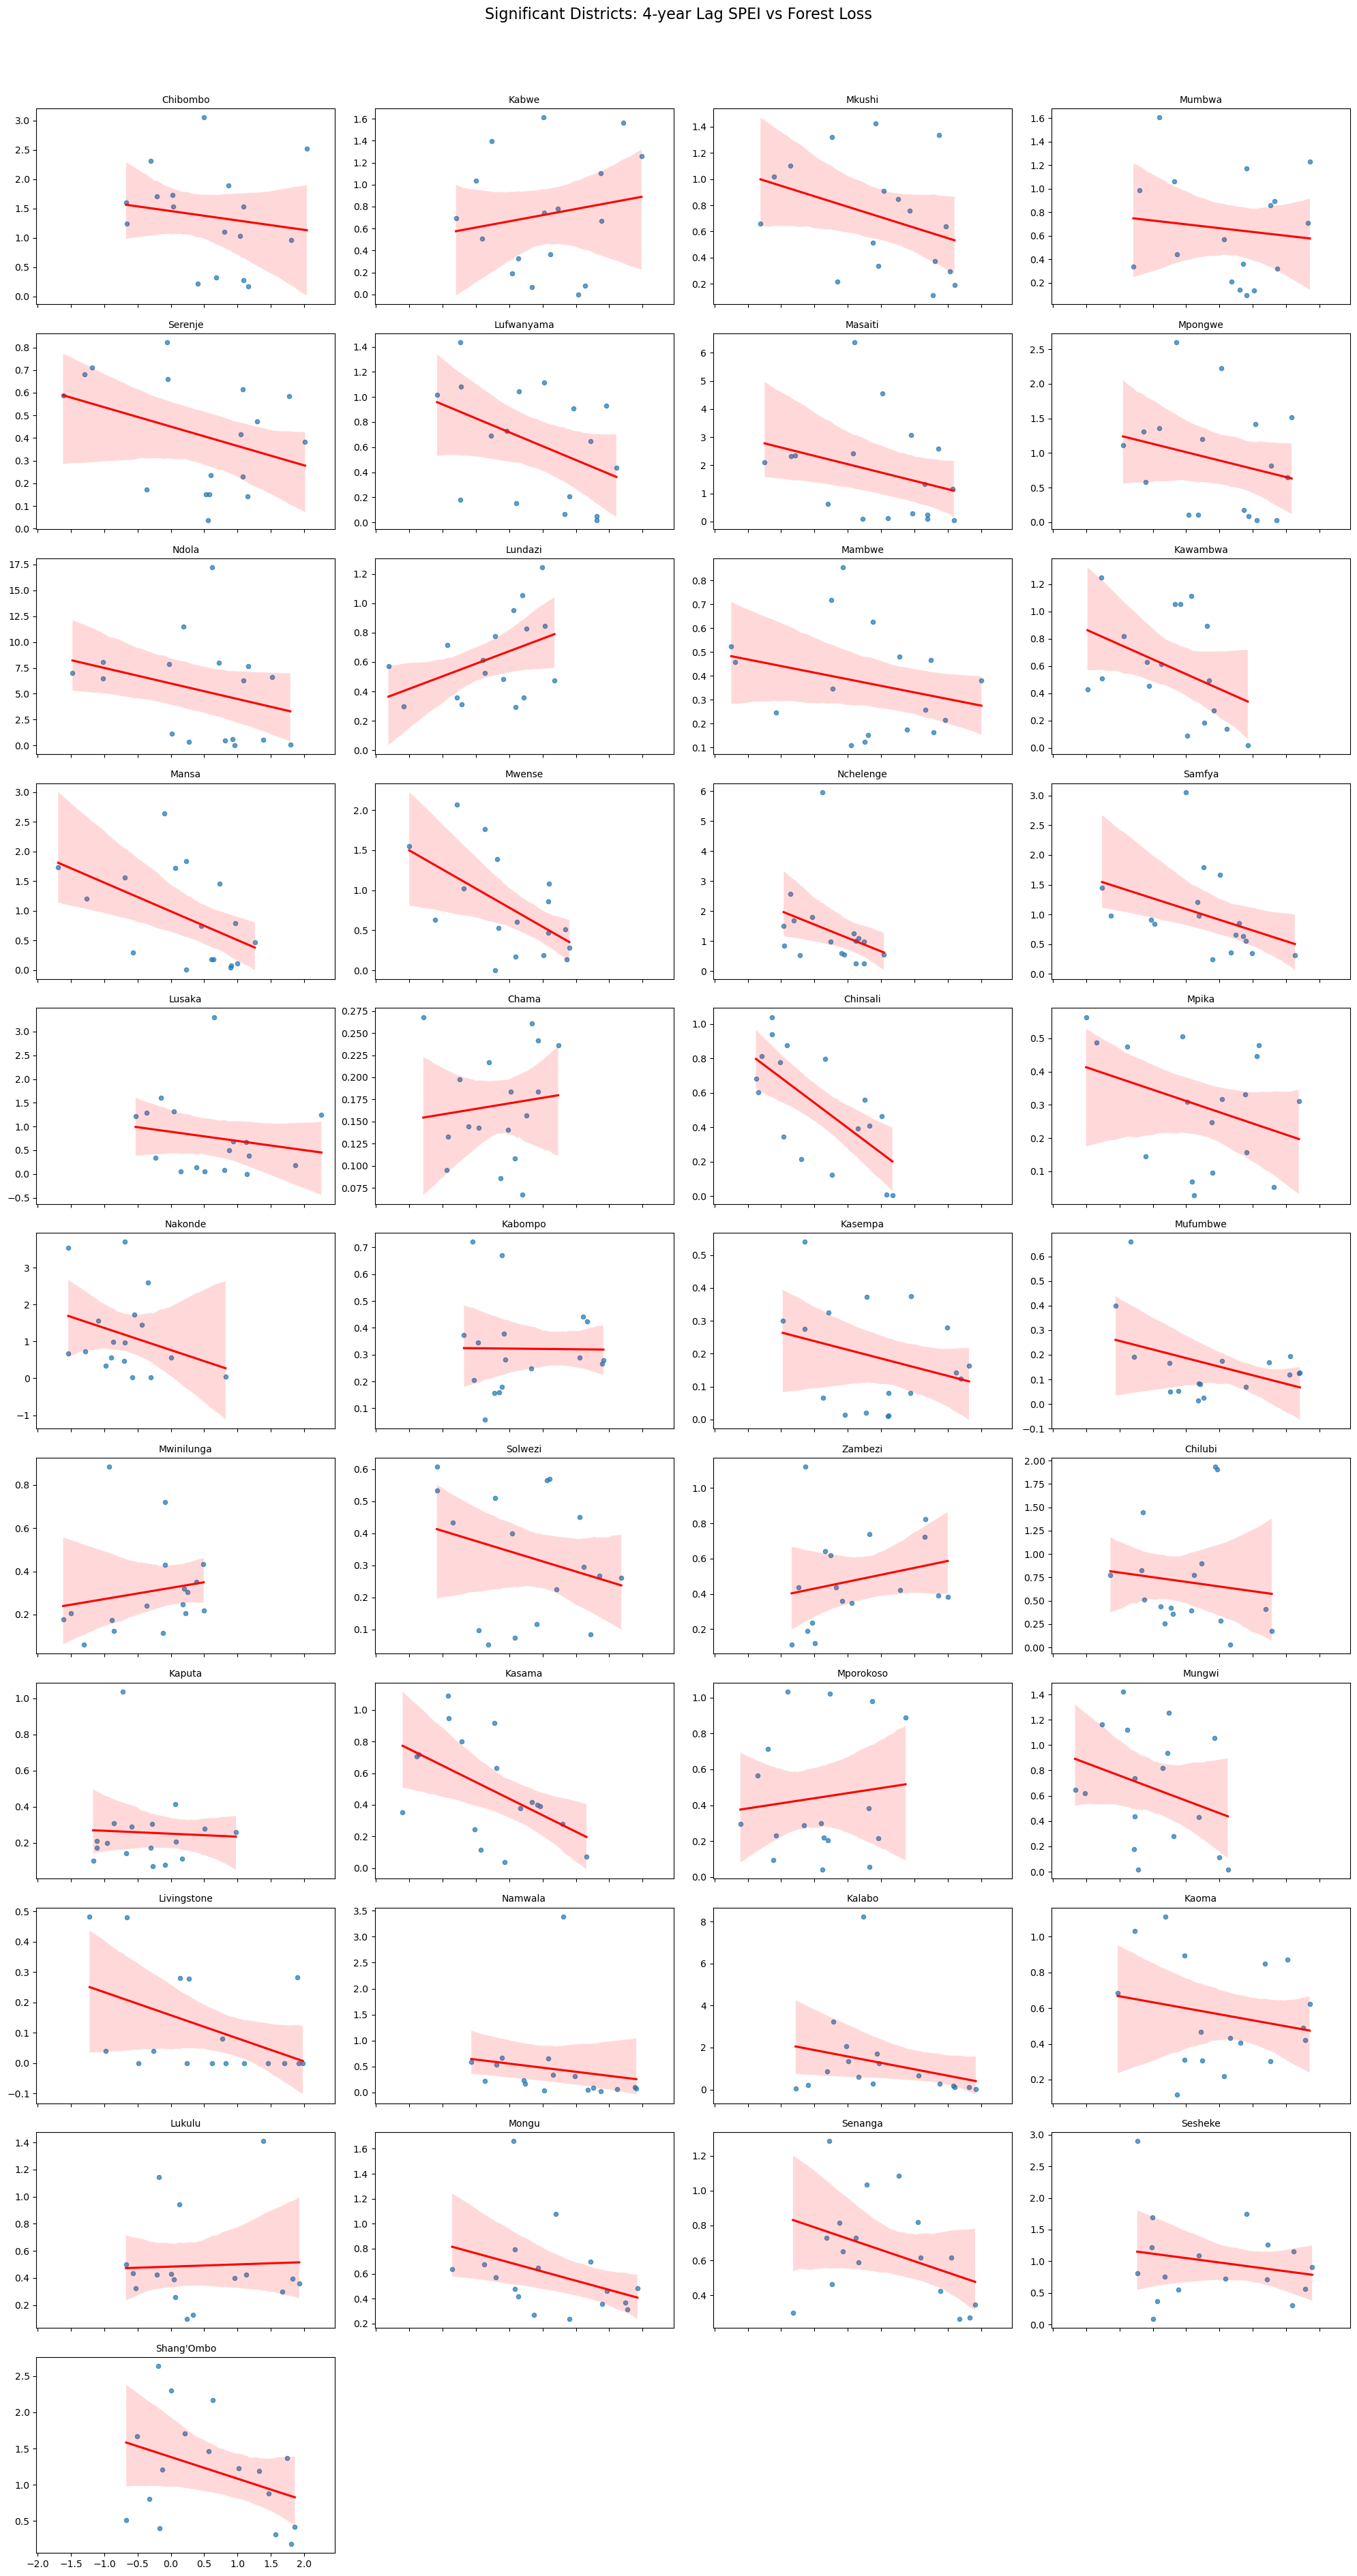

In [9]:
# statistically significant relationships between 4-yr lag SPEI and forest loss
significant_districts = [
 'Chibombo',
 'Kabwe',
 'Mkushi',
 'Mumbwa',
 'Serenje',
 'Lufwanyama',
 'Masaiti',
 'Mpongwe',
 'Ndola',
 'Lundazi',
 'Mambwe',
 'Kawambwa',
 'Mansa',
 'Mwense',
 'Nchelenge',
 'Samfya',
 'Lusaka',
 'Chama',
 'Chinsali',
 'Mpika',
 'Nakonde',
 'Kabompo',
 'Kasempa',
 'Mufumbwe',
 'Mwinilunga',
 'Solwezi',
 'Zambezi',
 'Chilubi',
 'Kaputa',
 'Kasama',
 'Mporokoso',
 'Mungwi',
 'Livingstone',
 'Namwala',
 'Kalabo',
 'Kaoma',
 'Lukulu',
 'Mongu',
 'Senanga',
 'Sesheke',
 "Shang'Ombo"
]

subset = cleaned[cleaned['district'].isin(significant_districts)]

n = len(significant_districts)
ncols = 4
nrows = math.ceil(n / ncols)

# set up figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3.5), sharex=True, sharey=False)
axes = axes.flatten()

# plot each district
for i, district in enumerate(significant_districts):
    ax = axes[i]
    district_df = subset[subset['district'] == district]

    sns.regplot(
        data=district_df,
        x='mean_spei_lag4',
        y='percent_loss_annual',
        ax=ax,
        scatter_kws={'s': 20, 'alpha': 0.7},
        line_kws={'color': 'red'},
    )
    ax.set_title(district, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Significant Districts: 4-year Lag SPEI vs Forest Loss', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()